In [1]:
#%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
# load some utilities (for loading MNIST and plotting)
# also imports most Python modules
_#%run utils.py

# load MNIST training and test data sets
train_dataset = datasets.MNIST(
  root = 'data',
  train = True,                         
  transform = ToTensor(), 
  download = True,            
  )
test_dataset = datasets.MNIST(
  root = 'data', 
  train = False, 
  transform = ToTensor()
  )
#train_dataset, test_dataset = MNIST_datasets()

# load tensors with all MNIST images and labels
#train_data, train_labels = MNIST()
#test_images, test_labels = MNIST(test=True)

train_data = train_dataset.data/255
train_labels = train_dataset.targets

train_images = train_dataset.data/255
train_labels = train_dataset.targets

test_images = test_dataset.data/255
test_labels = test_dataset.targets

# Variational Autoencoder

Is it reasonable to assume that we can generate images similar to the ones in the MNIST data set by a linear transformation of low dimensional latent variables?

Let us reflect on the limitations of PCA and PPCA. In both models, data is encoded in a lower dimensional space by a linear (or rather affine) transformation, and the lower dimensional representation can be decoded
by another affine function. One implication is that relative distances are preserved between the original space and the lower-dimensional latent space: if two data samples are "close" to each other, then also their latent encodings are relatively "close" to each other, and similarly two latent encodings that are "close" to each other are decoded to two relatively "close" data points. This affects our ability to reconstruct images from their encodings and to generate new images.

Let us consider a more flexible non-linear model that is given by 
\begin{align*}
  p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}) &= \mathcal{N}\left(\mathbf{x}; \mu_{\boldsymbol{\theta}}(\mathbf{z}), \sigma_{\boldsymbol{\theta}}^2 \mathbf{I}_{784}\right), \\
  p_{\boldsymbol{\theta}}(\mathbf{z}) &= \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_2),
\end{align*}
where parameters $\boldsymbol{\theta}$ include variance parameter $\sigma^2_{\boldsymbol{\theta}} > 0$ and $\mu_{\boldsymbol{\theta}} \colon \mathbb{R}^2 \to \mathbb{R}^{784}$ is a nonlinear model of the mean of the normal distribution. In this lab we model $\mu_{\boldsymbol{\theta}}$ by a neural network and include its weights and biases in $\boldsymbol{\theta}$, but other models could be used equally well.

This nonlinear model looks similar to the PPCA model above. However, in contrast to the PPCA model, for most classes of functions $\mu_{\boldsymbol{\theta}}$ the marginal distribution of $\mathbf{x}$ is not a normal distribution anymore, and typically there exists not even a closed form expression for its density.
Thus usually we can not learn the parameters $\boldsymbol{\theta}$ in the same straightforward way as for the PPCA model by minimizing the negative log-likelihood with gradient descent.

https://mustafaghali11.medium.com/how-pytorch-backward-function-works-55669b3b7c62

## Training: Variational autoencoder

### Introduction

There are at least two problems with the nonlinear model and our training procedure so far:
- For most samples of
$\mathbf{z}$, $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})$ is almost zero. Hence these
terms will not contribute much to the estimation of $p_{\boldsymbol{\theta}}(\mathbf{x})$,  which can slow down the training procedure.
- An even more fundamental problem with the nonlinear model is the fact that
usually we can not compute an analytical expression for
$p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$. Thus we can not encode
data in the lower dimensional latent space and analyze its structure.

The main idea of a so-called variational autotoencoder (VAE) is to resolve the first issue by attempting to obtain samples
$\mathbf{z}$ for which $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})$ is large.

### ELBO

Let us define an encoding distribution $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ that may depend on $\mathbf{x}$ and some parameters $\boldsymbol{\phi}$. As shown in the lecture, then we have
\begin{equation*}
    \log p_{\boldsymbol{\phi}}(\mathbf{x}) =
    \mathbb{E}_{\mathbf{z} \sim q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})\big]
    + \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z} \,|\,\mathbf{x})\big) - \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z})\big),
\end{equation*}
for all $\mathbf{x}$ (we ignore here that the KL-divergence $\mathrm{KL}(p \,\|\, q)$ is only defined if $q_{\boldsymbol{\phi}}(x) = 0$ implies $p_{\boldsymbol{\theta}}(x) = 0$).

The KL divergence of two distributions is always non-negative, and zero if and only if the two distributions are equal. Hence we have for all $\mathbf{x}$
\begin{equation*}
  \log p_{\boldsymbol{\theta}}(\mathbf{x}) \geq
  \mathbb{E}_{\mathbf{z} \sim q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})\big]
  - \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z})\big)
\end{equation*}
with equality if and only if $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ is equal to
the distribution $p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$. Since the
right-hand side of this inequality is a lower bound of the evidence $\log p_{\boldsymbol{\theta}}(\mathbf{x})$, it is called evidence lower bound (ELBO).

Remember that we know $p_{\boldsymbol{\theta}}(\mathbf{z}) = \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_2)$ from the model specification. Moreover, $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$ is an
arbitrary distribution that we can define in such a way that we can
compute $\mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\boldsymbol{\theta}}(\mathbf{z})\big)$
analytically. From the lab instructions, we know that we obtain
\begin{equation*}
    \mathrm{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) \,\|\, p_{\boldsymbol{\theta}}(\mathbf{z})\big) = \frac{1}{2} \left(\sum_{n=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n + \|\mu_{\boldsymbol{\phi}}(\mathbf{x})\|^2_2 - 2 - \sum_{n=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n\right),
\end{equation*}
if we choose the encoding distribution
\begin{equation}\label{eq:encoder}
  q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x}) = \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))),
\end{equation}
where $\mu_{\boldsymbol{\phi}}(\cdot) \colon \mathbb{R}^{784} \to \mathbb{R}^2$ defines the mean of the normal distribution and $\sigma_{\boldsymbol{\phi}}^2 \colon \mathbb{R}^{784} \to \mathbb{R}_{\geq 0}^2$ are the diagonal entries of the covariance matrix.

Thus for this encoding distribution the ELBO is
\begin{equation}
 \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x})))}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})\big]
 - \frac{1}{2} \left(\sum_{n=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n + \|\mu_{\boldsymbol{\phi}}(\mathbf{x})\|^2_2 - 2 - \sum_{n=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))\right),
\end{equation}
which we can approximate with the Monte Carlo estimate
\begin{equation}
  \frac{1}{K} \sum_{n=1}^K \log p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}_n) - \frac{1}{2} \left(\sum_{n=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n + \|\mu_{\boldsymbol{\phi}}(\mathbf{x})\|^2_2 - 2 - \sum_{n=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_n\right),
\end{equation}
where $\mathbf{z}_1, \ldots, \mathbf{z}_K$ are independent samples from $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})= \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x})))$.  The fundamental difference to the Monte Carlo estimation of the log-likelihood above is that before we had to sample from $p_{\boldsymbol{\theta}}(\mathbf{z}) = \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_2)$ whereas now we sample them from the encoding distribution $q$. Thus hopefully we can tune the parameters $\boldsymbol{\phi}$ of the encoding distribution such that $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}_n)$ increases, i.e., that it becomes more likely to reconstruct $\mathbf{x}$ from the samples $\mathbf{z}_n$.

This observation motivates the idea of maximizing the ELBO by training parameters $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$ simultaneously instead of maximizing the evidence $\log p_{\boldsymbol{\theta}}(\mathbf{x})$ by training only $\boldsymbol{\theta}$. If the encoding distribution is flexible enough, we might even be able to obtain the distribution $p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$, in which case the ELBO is actually
equal to the evidence.

Additionally, if we manage that distribution $q$ becomes equal to the distribution $p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$ (or at least close to it), we have found a way to encode our data: for a given data sample $\mathbf{x}$, we can just sample the latent encoding from $q_{\boldsymbol{\phi}}(\mathbf{z}; \mathbf{x})$. So by introducing the encoding distribution and maximizing the ELBO, we might be able to solve both problems of the nonlinear model.

### Cost function

In the same way, for a set of training data $\mathbf{x}_1, \ldots, \mathbf{x}_N$ we obtain
\begin{equation*}
    \begin{split}
    \log p_{\boldsymbol{\theta}}(\mathbf{x}_1, \ldots, \mathbf{x}_N) &= \sum_{n=1}^N \log p_{\boldsymbol{\theta}}(\mathbf{x}_n) \\
    &\geq \sum_{n=1}^N \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}_n), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n)))}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x}_n \,|\, \mathbf{z})\big] \\
   &\quad - \frac{1}{2} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - 2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
    \end{split}
\end{equation*}
and thus we can estimate the joint ELBO by
\begin{equation*}
    \begin{split}
     & \sum_{n=1}^N \frac{1}{K} \sum_{n'=1}^K \log p_{\boldsymbol{\theta}}(\mathbf{x}_n \,|\, \mathbf{z}_{n,n'})
  - \frac{1}{2} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - 2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}))_i\right) \\
     ={}& - \frac{1}{2}\left(784 N \left(\log{(2\pi)} + \log{\sigma_{\boldsymbol{\theta}}^2})\right) + \frac{1}{\sigma_{\boldsymbol{\theta}}^2}\sum_{n=1}^N \frac{1}{K} \sum_{n'=1}^K \|\mu_{\boldsymbol{\theta}}(\mathbf{z}_{n,n'}) - \mathbf{x}_n\|^2_2 \right) \\
     & - \frac{1}{2} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - 2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
     \end{split}
\end{equation*}
where $\mathbf{z}_{n,1}, \ldots, \mathbf{z}_{n,N}$ are independent samples of the encoding distribution $\mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}_n), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n)))$.

Since we use a stochastic optimization algorithm anyway, we choose $K = 1$, i.e., we use only one Monte Carlo sample for each training data sample. After neglecting additive constant terms and scaling by $N/2$, we obtain the cost function
\begin{equation*}
 J(\boldsymbol{\theta}, \boldsymbol{\phi}) = 784 \log{\sigma_{\boldsymbol{\theta}}^2} + \frac{1}{N \sigma_{\boldsymbol{\theta}}^2} \sum_{n=1}^N  \|\mu_{\boldsymbol{\theta}}(\mathbf{z}_n) - \mathbf{x}_n\|^2_2 + \frac{1}{N} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
\end{equation*}
where $\mathbf{z}_n$ are samples from $\mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}_n), \mathrm{diag}(\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n)))$. We will minimize this cost function with stochastic gradient descent.

### Reparameterization trick

However, there is one problem: it is not clear how to differentiate through the sampling operation of $\mathbf{z}_n$ with respect to the parameters $\boldsymbol{\phi}$ that determine the mean and variance of the distribution we sample from. We can generate samples from an arbitrary normal distribution by an affine transformation of standard normally distributed samples. Thus we can rewrite the cost function as
\begin{equation*}
    \begin{split}
 J(\boldsymbol{\theta}, \boldsymbol{\phi}) &= 784 \log{\sigma_{\boldsymbol{\theta}}^2} + \frac{1}{N \sigma_{\boldsymbol{\theta}}^2} \sum_{n=1}^N  \|\mu_{\boldsymbol{\theta}}(\mu_{\boldsymbol{\phi}}(\mathbf{x}_n) + \mathrm{diag}(\sigma_{\boldsymbol{\phi}}(\mathbf{x}_n)) \boldsymbol{\epsilon}_n) - \mathbf{x}_n\|^2_2 \\
 &\quad + \frac{1}{N} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
 \end{split}
\end{equation*}
where $\boldsymbol{\epsilon}_n$ are samples from the normal distribution $\mathcal{N}(\boldsymbol{0}, \mathbf{I}_2)$. Rewriting the cost function in this form is known as reparameterization trick and allows us to differentiate the cost function with respect to $\boldsymbol{\phi}$ in a straightforward way, since the samples $\boldsymbol{\epsilon}_n$ do not depend on the parameters anymore.

We now consider the following nonlinear model, in which in addition to the nonlinear model above we also implement an encoding distribution. The mean and the logarithm of the diagonal entries of the covariance matrix of the encoding distribution are modeled by a shallow neural network, and the `encode` function returns them for a batch of inputs. As above, the `decode` function outputs the representative decoding for a batch of encodings.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()

        # linear parts of the nonlinear encoder
        self.encoder_fc1 = nn.Linear(784, 400)
        self.encoder_fc2_mean = nn.Linear(400, 2)
        self.encoder_fc2_logsigma2 = nn.Linear(400, 2)

        # linear parts of the nonlinear function mu_phi
        self.decoder_fc1 = nn.Linear(2, 400)
        self.decoder_fc2 = nn.Linear(400, 784)

        # logarithm of variance sigma_phi^2
        self.logsigma2 = nn.Parameter(torch.zeros(1))

    def encode(self, x):
        h1 = F.relu(self.encoder_fc1(x))
        return self.encoder_fc2_mean(h1), self.encoder_fc2_logsigma2(h1)

    def decode(self, z):
        h1 = F.relu(self.decoder_fc1(z))
        return self.decoder_fc2(h1)

## Task 5

Read through and try to understand the definition of the nonlinear model.

As discussed above, one term of the cost function is the term
\begin{equation}
\frac{1}{N} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
\end{equation}
that originates from the KL divergence expression in the ELBO.

## Task 6

Implement the function `kl_divergence_term(Z_mu, Z_logsigma2)` that evaluates the expression above, where the rows of `Z_mu` are $\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)$ and the rows of `Z_logsigma2` are $\begin{bmatrix} \log (\sigma^2_{\boldsymbol{\phi}}(\mathbf{x}_n))_1 & \log (\sigma^2_{\boldsymbol{\phi}}(\mathbf{x}_n))_2\end{bmatrix}^\intercal$.

*Hint*: You should probably use the PyTorch functions [`torch.mean`](https://pytorch.org/docs/stable/torch.html#torch.mean), [`torch.sum`](https://pytorch.org/docs/stable/torch.html#torch.sum), [`torch.exp`](https://pytorch.org/docs/stable/torch.html#torch.exp), and [`torch.pow`](https://pytorch.org/docs/stable/torch.html#torch.pow) in your implementation.

In [3]:
def kl_divergence_term(Z_mu, Z_logsigma2):
    # compute the average KL divergence to the standard normal
    # distribution, neglecting additive constant terms
    sigma2 = torch.exp(Z_logsigma2)

    term = torch.mean(torch.sum(sigma2 ,dim=1) + torch.sum(torch.pow(Z_mu ,2), dim=1) - torch.sum(Z_logsigma2, dim=1))
    return term

We make use of the `kl_divergence_term` function in our implementation of the cost function.

In [4]:
def cost_function(X, model):
    # compute mean and log variance of the normal distribution of
    # the encoding z of input X
    Z_mu, Z_logsigma2 = model.encode(X)
    #print(f'Z_mu:               {Z_mu[0,0]}')
    #print(f'Z_logsigma2:        {Z_logsigma2[0,0]}')

    # compute the average KL divergence to the prior standard normal
    # distribution of z, neglecting constant terms
    # expected log p(x | z) + C
    kl = kl_divergence_term(Z_mu, Z_logsigma2)
    #print(f'kl: {kl}')

    # sample z
    #Z = Z_mu + torch.randn(Z_mu.size()) * torch.exp(0.5 * Z_logsigma2)
    Z = Z_mu + torch.Tensor(np.ones(Z_mu.size())) * torch.exp(0.5 * Z_logsigma2)

    # compute the representative decoding of z
    X_decoding = model.decode(Z)

    # compute negative average evidence of the input x, neglecting additive constant terms
    neg_log_evidence = 784 * model.logsigma2 + \
        torch.sum((X_decoding - X).pow(2) * torch.exp(- model.logsigma2), dim=1).mean()

    return neg_log_evidence + kl, X_decoding, Z, Z_logsigma2

In [5]:
def cost_function_2(X, model):
    # compute mean and log variance of the normal distribution of
    # the encoding z of input X
    enc_h1 = model.encoder_fc1(X)
    Z_mu, Z_logsigma2 = model.encode(X)
    #print(f'Z_mu:               {Z_mu[0,0]}')
    #print(f'Z_logsigma2:        {Z_logsigma2[0,0]}')

    # compute the average KL divergence to the prior standard normal
    # distribution of z, neglecting constant terms
    # expected log p(x | z) + C
    kl = kl_divergence_term(Z_mu, Z_logsigma2)
    #print(f'kl: {kl}')

    # sample z
    #Z = Z_mu + torch.randn(Z_mu.size()) * torch.exp(0.5 * Z_logsigma2)
    Z = Z_mu + torch.Tensor(np.ones(Z_mu.size())) * torch.exp(0.5 * Z_logsigma2)

    # compute the representative decoding of z
    dec_h1 = model.decoder_fc1(Z)
    X_decoding = model.decode(Z)

    # compute negative average evidence of the input x, neglecting additive constant terms
    neg_log_evidence = 784 * model.logsigma2 + \
        torch.sum((X_decoding - X).pow(2) * torch.exp(- model.logsigma2), dim=1).mean()

    return neg_log_evidence + kl, X_decoding, Z, Z_logsigma2, dec_h1, enc_h1

In [6]:
def multi_cost_function(X, model1, model2):
    # compute mean and log variance of the normal distribution of
    # the encoding z of input X
    output_h1 = model2.encoder_fc1(X)
    Z_mu_1, Z_logsigma2_1 = model1.encode(X)
    Z_mu_2, Z_logsigma2_2 = model2.encode(X)
    #print(f'Z_mu:               {Z_mu[0,0]}')
    #print(f'Z_logsigma2:        {Z_logsigma2[0,0]}')

    # compute the average KL divergence to the prior standard normal
    # distribution of z, neglecting constant terms
    # expected log p(x | z) + C
    kl_1 = kl_divergence_term(Z_mu_1, Z_logsigma2_1)
    kl_2 = kl_divergence_term(Z_mu_2, Z_logsigma2_2)
    #print(f'kl: {kl}')

    # sample z
    rsamples = torch.randn(Z_mu_1.size())
    Z_1 = Z_mu_1 + rsamples * torch.exp(0.5 * Z_logsigma2_1)
    Z_2 = Z_mu_2 + rsamples * torch.exp(0.5 * Z_logsigma2_2)
    #Z = Z_mu + torch.Tensor(np.ones(Z_mu.size())) * torch.exp(0.5 * Z_logsigma2)

    # compute the representative decoding of z
    output_d1 = model2.decoder_fc1(Z_1)
    X_decoding_1 = model1.decode(Z_1)
    X_decoding_2 = model2.decode(Z_2)

    # compute negative average evidence of the input x, neglecting additive constant terms
    neg_log_evidence_1 = 784 * model1.logsigma2 + \
        torch.sum((X_decoding_1 - X).pow(2) * torch.exp(- model1.logsigma2), dim=1).mean()
    
    neg_log_evidence_2 = 784 * model2.logsigma2 + \
        torch.sum((X_decoding_2 - X).pow(2) * torch.exp(- model2.logsigma2), dim=1).mean()

    return neg_log_evidence_1 + kl_1, neg_log_evidence_1 + kl_1, X_decoding_1, X_decoding_2, Z_1, Z_2, Z_logsigma2_1, Z_logsigma2_2, output_h1, output_d1

# Reconstruction error
Equation: 
\begin{equation}
    \frac{\partial MSE}{\partial X_{decoding}} = 2 \cdot (X_{decoding} - X) \cdot exp(-logsigma2)
\end{equation}

# KL divergence error
Equation: 
\begin{equation}
    \frac{\partial KL}{\partial Z_{\mu}} = 2 \cdot Z_{\mu}
\end{equation}

Equation: 
\begin{equation}
    \frac{\partial KL}{\partial Z_{logsigma2}} = exp(Z_{logsigma2})-1
\end{equation}

In [7]:
def reconstruction_error(X_decoding, X, model):
    N = X.size()[0]
    diff = X_decoding - X
    recon_error = (2 / N) * diff * torch.exp(-model.logsigma2)
    # Gradient w.r.t logsigma2
    diff2 = diff.pow(2)
    dL_dlogsigma2 = 2*torch.sum((1/2)- (diff2/(2*torch.exp(model.logsigma2))))/N

    return recon_error, dL_dlogsigma2

In [8]:
def KL_divergence_error(X, model):
    batch_size = X.size()[0]
    Z_mu, Z_logsigma2 = model.encode(X)
    dKL_dZmu = (2*Z_mu)/batch_size
    dKL_dZlogsig = (torch.exp(Z_logsigma2)-1)/batch_size
    return dKL_dZmu, dKL_dZlogsig

# Backpropagation Through the Decoder:
## Steps:
1. Backpropagation through decoder_fc2 (Linear Layer):
- Input to this layer: h1 from decoder_fc1.
- Output of this layer: X_decoding.
- Loss Gradient with respect to the output: Let's denote it as $\frac{\partial L}{\partial X_{decoding}}$

Compute the gradient of the loss with respect to the weight (W_fc2) and biases (b_fc2) of decoder_fc2.
* Gradient w.r.t. weights 
\begin{equation}
\frac{\partial L}{\partial W_{fc2}} = \frac{\partial L}{\partial X_{decoding}} \cdot h_1^T
\end{equation}

* Gradient w.r.t. biases 
\begin{equation}
\frac{\partial L}{\partial b_{fc2}} = \frac{\partial L}{\partial X_{decoding}}
\end{equation}
 
Compute the gradient of the loss with respect to the input of decoder_fc2 (which is the output of decoder_fc1, denoted as h1).
\begin{equation}
\frac{\partial L}{\partial h_1} = W_{fc_2}^T \cdot \frac{\partial L}{\partial X_{decoding}}
\end{equation}
​
 
2. Backpropagation through decoder_fc1 (Linear Layer + ReLU):
- Input to this layer: z (latent representation).
- Output of this layer: h1.

Apply the chain rule through the ReLU activation function.
The gradient is passed unchanged where the input to ReLU was positive, and zeroed out where it was negative.
\begin{equation}
\frac{\partial L}{\partial h_1preReLU} = ReLU'(h_1) \cdot \frac{\partial L}{\partial h_1}
\end{equation}
 
Compute the gradients w.r.t. the weight (W_fc1) and biases (b_fc1) of decoder_fc1.

* Gradient w.r.t. weights 
\begin{equation}
\frac{\partial L}{\partial W_{fc1}} = \frac{\partial L}{\partial \partial h_1preReLU} \cdot Z^T
\end{equation}

* Gradient w.r.t. biases 
\begin{equation}
\frac{\partial L}{\partial b_{fc1}} = \frac{\partial L}{\partial \partial h_1preReLU}
\end{equation}
 


In [9]:
activation = {}
def get_activation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

def der_ReLU(x):
  return (x>0)*1.0

In [10]:
def backprop_decoder(X, model, X_decoding, h1, z, Z_logsigma2):
    
    dL_dWfc1 = []
    dL_dbfc1 = []
    dL_dWfc2 = []
    dL_dbfc2 = []

    batch_size = X.size()[0]
    dL_dXdec, dL_dlogsigma2 = reconstruction_error(X_decoding, X, model)
    dL_dWfc2 = (h1.T @ dL_dXdec)
    dL_dbfc2 = dL_dXdec.sum(dim=0)

    dL_dh1 = dL_dXdec @ model.decoder_fc2.weight.data
    dL_dh1_preReLu = der_ReLU(h1) * dL_dh1
    dL_dWfc1 = (z.T @ dL_dh1_preReLu)
    dL_dbfc1 = (dL_dh1_preReLu.sum(dim=0))

    # Compute gradients w.r.t z (latent variable)
    dL_dz = dL_dh1_preReLu @ model.decoder_fc1.weight.data

    # Backpropagate through reparameterization trick
    dL_dZmu = dL_dz  # Gradient w.r.t Z_mu is direct
    dL_dZlogsig = dL_dz * 0.5 * torch.exp(0.5 * Z_logsigma2)

    return [dL_dZmu, dL_dZlogsig, dL_dWfc1.T, dL_dbfc1.T, dL_dWfc2.T, dL_dbfc2, nn.Parameter(torch.tensor(dL_dlogsigma2))]


# Backpropagation Through the Encoder:
## Steps:
1. Backpropagation through encoder_fc2_mean and encoder_fc2_logsigma2 (Linear Layers):
- Input to these layers: h1 from encoder_fc1.
- Outputs of these layers: Z_mu and Z_logsigma2.
- Loss Gradients with respect to the outputs: Denoted as $\frac{\partial L}{\partial Z_mu}$ and $\frac{\partial L}{\partial Z_{logsigma2}}$ respectively.

Compute the gradient of the loss with respect to the weights and biases of both encoder_fc2_mean and encoder_fc2_logsigma2.

For encoder_fc2_mean:
* Gradient w.r.t. weights 
\begin{equation}
\frac{\partial L}{\partial W_{mean}} = \frac{\partial L}{\partial Z_{\mu}} \cdot h_1^T
\end{equation}

* Gradient w.r.t. biases 
\begin{equation}
\frac{\partial L}{\partial b_{mean}} = \frac{\partial L}{\partial Z_{\mu}}
\end{equation}

For encoder_fc2_logsigma2:
* Gradient w.r.t. weights 
\begin{equation}
\frac{\partial L}{\partial W_{logsigma2}} = \frac{\partial L}{\partial Z_{logsigma2}} \cdot h_1^T
\end{equation}

* Gradient w.r.t. biases 
\begin{equation}
\frac{\partial L}{\partial b_{logsigma2}} = \frac{\partial L}{\partial Z_{logsigma2}}
\end{equation}

Compute the gradient of the loss with respect to the input of these layers (which is the output of encoder_fc1, denoted as h1).
\begin{equation}
\frac{\partial L}{\partial h_1} = W_{mean}^T \cdot \frac{\partial L}{\partial Z_{\mu}} + W_{logsigma2}^T \cdot \frac{\partial L}{\partial Z_{logsigma2}}
\end{equation}
 
1. Backpropagation through encoder_fc1 (Linear Layer + ReLU):
- Input to this layer: Input data x.
- Output of this layer: h1.

* Apply the chain rule through the ReLU activation function.
* The gradient is passed unchanged where the input to ReLU was positive, and zeroed out where it was negative.
\begin{equation}
\frac{\partial L}{\partial h_1preReLU} = ReLU'(h_1) \cdot \frac{\partial L}{\partial h_1}
\end{equation}
​
 
Compute the gradients w.r.t. the weights (W_fc1) and biases (b_fc1) of encoder_fc1.
* Gradient w.r.t. weights 
\begin{equation}
\frac{\partial L}{\partial W_{fc_1}} = \frac{\partial L}{\partial h_1preReLU} \cdot x^T
\end{equation}
 
* Gradient w.r.t. biases 
\begin{equation}
\frac{\partial L}{\partial b_{fc_1}} = \frac{\partial L}{\partial h_1preReLU}
\end{equation}


In [11]:
def backprop_encoder(X, model, X_decoding, h1, z, dz_mu_rec, dz_logsig_rec):
    dKL_dZmu, dKL_dZlogsig = KL_divergence_error(X, model)

    dL_dWmean = []
    dL_dbmean = []
    dL_dWlogsigma2 = []
    dL_dblogsigma2 = []
    dL_dWfc1 = []
    dL_dbfc1 = []

    dKL_dZmu = dKL_dZmu + dz_mu_rec
    dKL_dZlogsig = dKL_dZlogsig + dz_logsig_rec
    dL_dWmean = (h1.T @ dKL_dZmu)
    dL_dbmean = dKL_dZmu.sum(dim=0)

    dL_dWlogsigma2 = (h1.T @ dKL_dZlogsig)
    dL_dblogsigma2 = dKL_dZlogsig.sum(dim=0)

    dL_dh1 = (model.encoder_fc2_mean.weight.data.T @ dKL_dZmu.T + model.encoder_fc2_logsigma2.weight.data.T @ dKL_dZlogsig.T)

    dL_dh1_preReLu = der_ReLU(h1) * dL_dh1.T

    dL_dWfc1 = (dL_dh1_preReLu.T @ X)
    dL_dbfc1 = dL_dh1_preReLu.sum(dim=0)

    return [dL_dWmean.T, dL_dbmean, dL_dWlogsigma2.T, dL_dblogsigma2, dL_dWfc1, dL_dbfc1]


In [44]:
def update_weights_manually(model, decoder_params, encoder_params, rate):

    grads = encoder_params + decoder_params[2:]

    model.decoder_fc1.weight.data = model.decoder_fc1.weight.data - grads[6]*rate
    model.decoder_fc1.bias.data = model.decoder_fc1.bias.data - grads[7]*rate
    model.decoder_fc2.weight.data = model.decoder_fc2.weight.data - grads[8]*rate
    model.decoder_fc2.bias.data = model.decoder_fc2.bias.data - grads[9]*rate

    # Update logsigma2
    model.logsigma2.data = model.logsigma2.data - nn.Parameter(grads[10]*rate)

    model.encoder_fc2_mean.weight.data = model.encoder_fc2_mean.weight.data - (grads[0]*rate)
    model.encoder_fc2_mean.bias.data = model.encoder_fc2_mean.bias.data - (grads[1]*rate)
    model.encoder_fc2_logsigma2.weight.data = model.encoder_fc2_logsigma2.weight.data - (grads[2]*rate)
    model.encoder_fc2_logsigma2.bias.data = model.encoder_fc2_logsigma2.bias.data - (grads[3]*rate)
    model.encoder_fc1.weight.data = model.encoder_fc1.weight.data - (grads[4]*rate)
    model.encoder_fc1.bias.data = model.encoder_fc1.bias.data - (grads[5]*rate)

In [13]:
def adam_optimizer(model, dec_grads, enc_grads, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, m=None, v=None, t=0):
    """
    Manual implementation of the Adam optimization algorithm for PyTorch tensors.

    Args:
    - params (list of torch.Tensor): Parameters of the model.
    - grads (list of torch.Tensor): Gradients of the loss w.r.t. each parameter.
    - lr (float): Learning rate.
    - beta1 (float): Exponential decay rate for the first moment estimates.
    - beta2 (float): Exponential decay rate for the second moment estimates.
    - epsilon (float): Small number to prevent division by zero.
    - m (list of torch.Tensor): First moment vector (moving average of the gradient).
    - v (list of torch.Tensor): Second moment vector (moving average of the squared gradient).
    - t (int): Time step.

    Returns:
    - params (list of torch.Tensor): Updated parameters.
    - m (list of torch.Tensor): Updated first moment vector.
    - v (list of torch.Tensor): Updated second moment vector.
    - t (int): Updated time step.
    """
    grads = enc_grads + dec_grads[2:]
    params = [model.encoder_fc2_mean.weight.data,
              model.encoder_fc2_mean.bias.data,
              model.encoder_fc2_logsigma2.weight.data,
              model.encoder_fc2_logsigma2.bias.data,
              model.encoder_fc1.weight.data,
              model.encoder_fc1.bias.data,
              model.decoder_fc1.weight.data,
              model.decoder_fc1.bias.data,
              model.decoder_fc2.weight.data,
              model.decoder_fc2.bias.data,
              model.logsigma2]
    
    if m is None:
        m = [torch.zeros_like(p) for p in params]
    if v is None:
        v = [torch.zeros_like(p) for p in params]

    t += 1
    m = [beta1 * m_i + (1 - beta1) * g for m_i, g in zip(m, grads)]
    v = [beta2 * v_i + (1 - beta2) * (g ** 2) for v_i, g in zip(v, grads)]

    m_hat = [m_i / (1 - beta1 ** t) for m_i in m]
    v_hat = [v_i / (1 - beta2 ** t) for v_i in v]

    params = [p - ((lr * m_h) / (torch.sqrt(v_h) + epsilon)) for p, m_h, v_h in zip(params, m_hat, v_hat)]

    model.encoder_fc2_mean.weight.data = params[0]
    model.encoder_fc2_mean.bias.data = params[1]
    model.encoder_fc2_logsigma2.weight.data = params[2]
    model.encoder_fc2_logsigma2.bias.data = params[3]
    model.encoder_fc1.weight.data = params[4]
    model.encoder_fc1.bias.data = params[5]
    model.decoder_fc1.weight.data = params[6]
    model.decoder_fc1.bias.data = params[7]
    model.decoder_fc2.weight.data = params[8]
    model.decoder_fc2.bias.data = params[9]
    model.logsigma2 = nn.Parameter(params[10])

    params = []
    
    return params, m, v, t

Now we can train the nonlinear model.

In [14]:
def set_unit_weights(model_to_init):
    model_to_init.encoder_fc1.weight.data = model_to_init.encoder_fc1.weight.data*0.0 +0.011
    model_to_init.encoder_fc2_mean.weight.data = model_to_init.encoder_fc2_mean.weight.data*0.0 +0.011
    model_to_init.encoder_fc2_logsigma2.weight.data = model_to_init.encoder_fc2_logsigma2.weight.data*0.0 +0.011

    model_to_init.encoder_fc1.bias.data = model_to_init.encoder_fc1.bias.data*0.0 +0.011
    model_to_init.encoder_fc2_mean.bias.data = model_to_init.encoder_fc2_mean.bias.data*0.0 +0.011
    model_to_init.encoder_fc2_logsigma2.bias.data = model_to_init.encoder_fc2_logsigma2.bias.data*0.0 +0.011

    model_to_init.decoder_fc1.weight.data = model_to_init.decoder_fc1.weight.data*0.0 +0.011
    model_to_init.decoder_fc2.weight.data = model_to_init.decoder_fc2.weight.data*0.0 +0.011

    model_to_init.decoder_fc1.bias.data = model_to_init.decoder_fc1.bias.data*0.0 +0.011
    model_to_init.decoder_fc2.bias.data = model_to_init.decoder_fc2.bias.data*0.0 +0.011

In [15]:
def copy_weights(model_source, model_target):
    model_source.encoder_fc1.weight.data = model_target.encoder_fc1.weight.data*1.0
    model_source.encoder_fc2_mean.weight.data = model_target.encoder_fc2_mean.weight.data*1.0
    model_source.encoder_fc2_logsigma2.weight.data = model_target.encoder_fc2_logsigma2.weight.data*1.0

    model_source.encoder_fc1.bias.data = model_target.encoder_fc1.bias.data*1.0
    model_source.encoder_fc2_mean.bias.data = model_target.encoder_fc2_mean.bias.data*1.0
    model_source.encoder_fc2_logsigma2.bias.data = model_target.encoder_fc2_logsigma2.bias.data*1.0

    model_source.decoder_fc1.weight.data = model_target.decoder_fc1.weight.data*1.0
    model_source.decoder_fc2.weight.data = model_target.decoder_fc2.weight.data*1.0

    model_source.decoder_fc1.bias.data = model_target.decoder_fc1.bias.data*1.0
    model_source.decoder_fc2.bias.data = model_target.decoder_fc2.bias.data*1.0

In [22]:
import numpy as np
import torch.optim as optim

train_dataset = datasets.MNIST(
  root = 'data',
  train = True,                         
  transform = ToTensor(), 
  download = True,            
  )
test_dataset = datasets.MNIST(
  root = 'data', 
  train = False, 
  transform = ToTensor()
  )
# define the data loaders
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=400, shuffle=True)
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=400)

# define the model
model1 = VAE()
model2 = VAE()
#set_unit_weights(model1)
#set_unit_weights(model2)

# define the optimizer
optimizer = optim.Adam(model1.parameters(), lr=0.01)

copy_weights(model1, model2)

# track the training and test loss
training_loss = []
test_loss = []

training_loss2 = []
test_loss2 = []

mv = None
vv = None
t = 0

#model2.encoder_fc1.register_forward_hook(get_activation('enc_fc1'))
#model2.encoder_fc2_mean.register_forward_hook(get_activation('enc_fc2_mean'))
#model2.encoder_fc2_logsigma2.register_forward_hook(get_activation('enc_fc2_logsig'))

#model2.decoder_fc1.register_forward_hook(get_activation('dec_fc1'))
#model2.decoder_fc2.register_forward_hook(get_activation('dec_fc2'))
print("Model 1:")
print(torch.max(model2.decoder_fc1.weight.data))
print(torch.max(model2.decoder_fc2.weight.data))
print(torch.max(model2.encoder_fc1.weight.data))
print(torch.max(model2.encoder_fc2_logsigma2.weight.data))
print(torch.max(model2.encoder_fc2_mean.weight.data))

print("Model 2: ")
print(torch.max(model1.decoder_fc1.weight.data))
print(torch.max(model1.decoder_fc2.weight.data))
print(torch.max(model1.encoder_fc1.weight.data))
print(torch.max(model1.encoder_fc2_logsigma2.weight.data))
print(torch.max(model1.encoder_fc2_mean.weight.data))

# optimize parameters for 20 epochs
for i in range(35):

    # for each minibatch
    for x, _ in train_data:
        x = x.reshape(400,28*28)
        #print((x[0,:]))
        # evaluate the cost function on the training data set
        #loss_1, loss_2, X_dec_1, X_dec_2, Z_1, Z_2, Z_logsigma_1, Z_logsigma_2, dec_h1, enc_h1 = multi_cost_function(x, model1, model2)
        loss_1, xtrash, ztrash, trash = cost_function(x, model1)

        # update the statistics
        training_loss.append(loss_1.item())
        #print(f"Training loss {loss.item(): 9.3f}")
        test_loss.append(float('nan'))

        # perform backpropagation
        loss_1.backward()

        # manual
        loss_2, X_dec_2, Z_2, Z_logsigma_2, dec_h1, enc_h1 = cost_function_2(x, model2)
        #dec_h1 = activation['dec_fc1']
        #enc_h1 = activation['enc_fc1']
        dec_params = backprop_decoder(x, model2, X_dec_2, dec_h1, Z_2, Z_logsigma_2)
        enc_params = backprop_encoder(x, model2, X_dec_2, enc_h1, Z_2, dec_params[0], dec_params[1])
        param_trash, mv, vv, t = adam_optimizer(model2, dec_params, enc_params, lr = 0.01, m = mv, v = vv, t=t)

        training_loss2.append(loss_2.item())
        #print(f"Training loss 2 {loss2.item(): 9.3f}")
        test_loss2.append(float('nan'))

        # perform a gradient descent step
        optimizer.step()
        
        # reset the gradient information
        optimizer.zero_grad()

    print("Model 1:")
    print(torch.max(model2.decoder_fc1.weight.data))
    print(torch.max(model2.decoder_fc2.weight.data))
    print(torch.max(model2.encoder_fc1.weight.data))
    print(torch.max(model2.encoder_fc2_logsigma2.weight.data))
    print(torch.max(model2.encoder_fc2_mean.weight.data))

    print("Model 2: ")
    print(torch.max(model1.decoder_fc1.weight.data))
    print(torch.max(model1.decoder_fc2.weight.data))
    print(torch.max(model1.encoder_fc1.weight.data))
    print(torch.max(model1.encoder_fc2_logsigma2.weight.data))
    print(torch.max(model1.encoder_fc2_mean.weight.data))
    # evaluate the model after every epoch
    with torch.no_grad():

        # evaluate the cost function on the test data set
        accumulated_loss = 0
        accumulated_loss2 = 0
        for x, _ in test_data:
            x = x.reshape(400,28*28)
            #loss_1, loss_2, X_dec_1, X_dec_2, Z_1, Z_2, Z_logsigma_1, Z_logsigma_2, dec_h1, enc_h1 = multi_cost_function(x, model1, model2)
            loss_1, xtrash,ztrash, zlog_trash = cost_function(x, model1)
            loss_2, X_decoding, z, zlogsig = cost_function(x, model2)
            accumulated_loss += loss_1.item()
            accumulated_loss2 += loss_2.item()
            
        # update statistics
        test_loss[-1] = accumulated_loss / len(test_data)
        test_loss2[-1] = accumulated_loss2 / len(test_data)
            
    print(f"Epoch {i + 1:2d}: training loss {training_loss[-1]: 9.3f}, "
          f"test loss {test_loss[-1]: 9.3f}")
    print(f"Epoch {i + 1:2d}: training loss 2  {training_loss2[-1]: 9.3f}, "
          f"test loss 2 {test_loss2[-1]: 9.3f}")
        
# plot loss
plt.figure()
iterations = np.arange(1, len(training_loss) + 1)
plt.scatter(iterations, training_loss, label='training loss')
plt.scatter(iterations, test_loss, label='test loss')
plt.legend()
plt.xlabel('iteration')
plt.show()

plt.figure()
iterations = np.arange(1, len(training_loss2) + 1)
plt.scatter(iterations, training_loss2, label='training loss 2')
plt.scatter(iterations, test_loss2, label='test loss 2')
plt.legend()
plt.xlabel('iteration')
plt.show()

Model 1:
tensor(0.7064)
tensor(0.0500)
tensor(0.0357)
tensor(0.0500)
tensor(0.0497)
Model 2: 
tensor(0.7064)
tensor(0.0500)
tensor(0.0357)
tensor(0.0500)
tensor(0.0497)


C:\Users\LINRY~1.PRE\AppData\Local\Temp/ipykernel_24468/2406579183.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return [dL_dZmu, dL_dZlogsig, dL_dWfc1.T, dL_dbfc1.T, dL_dWfc2.T, dL_dbfc2, nn.Parameter(torch.tensor(dL_dlogsigma2))]


Model 1:
tensor(0.7005)
tensor(0.2130)
tensor(0.1466)
tensor(0.1871)
tensor(0.1378)
Model 2: 
tensor(0.7138)
tensor(0.7702)
tensor(0.3281)
tensor(0.0985)
tensor(0.0928)
Epoch  1: training loss  -857.456, test loss  -864.762
Epoch  1: training loss 2   -586.554, test loss 2  -593.989
Model 1:
tensor(0.7135)
tensor(0.3081)
tensor(0.2518)
tensor(0.1907)
tensor(0.1511)
Model 2: 
tensor(0.7878)
tensor(1.8669)
tensor(0.5384)
tensor(0.0985)
tensor(0.0928)
Epoch  2: training loss -1457.084, test loss -1452.894
Epoch  2: training loss 2  -1231.437, test loss 2 -1233.343
Model 1:
tensor(0.7026)
tensor(0.5314)
tensor(0.4158)
tensor(0.2456)
tensor(0.2174)
Model 2: 
tensor(0.8428)
tensor(2.2585)
tensor(1.0174)
tensor(0.0985)
tensor(0.0928)
Epoch  3: training loss -1571.646, test loss -1576.964
Epoch  3: training loss 2  -1414.772, test loss 2 -1436.408
Model 1:
tensor(0.7112)
tensor(0.7452)
tensor(0.4277)
tensor(0.2291)
tensor(0.2021)
Model 2: 
tensor(0.8474)
tensor(2.3777)
tensor(1.2206)
tensor(0.

KeyboardInterrupt: 

In [29]:
def compare_models(model1, model2):
    print(f'Max diff: {torch.max(model1.decoder_fc1.weight.data - model2.decoder_fc1.weight.data)}')
    print(f'Max diff: {torch.max(model1.decoder_fc2.weight.data - model2.decoder_fc2.weight.data)}')
    print(f'Max diff: {torch.max(model1.encoder_fc1.weight.data - model2.encoder_fc1.weight.data)}')
    print(f'Max diff: {torch.max(model1.encoder_fc2_logsigma2.weight.data - model2.encoder_fc2_logsigma2.weight.data)}')
    print(f'Max diff: {torch.max(model1.encoder_fc2_mean.weight.data - model2.encoder_fc2_mean.weight.data)}')
    print(f'Max diff: {torch.max(model1.logsigma2.data - model2.logsigma2.data)}\n\n')

    # print(f'dec_fc1 {torch.allclose(model1.decoder_fc1.weight.data, model2.decoder_fc1.weight.data)}')
    # print(f'dec_fc2 {torch.allclose(model1.decoder_fc2.weight.data, model2.decoder_fc2.weight.data)}')
    # print(f'enc_fc1 {torch.allclose(model1.encoder_fc1.weight.data, model2.encoder_fc1.weight.data)}')
    # print(f'enc_fc2_logsig {torch.allclose(model1.encoder_fc2_logsigma2.weight.data, model2.encoder_fc2_logsigma2.weight.data)}')
    # print(f'enc_fc2_mean {torch.allclose(model1.encoder_fc2_mean.weight.data, model2.encoder_fc2_mean.weight.data)}')
    # print(f'logsigma2 {torch.allclose(model1.logsigma2.data, model2.logsigma2.data)}')


In [47]:
import numpy as np
import torch.optim as optim

size_of_batch = 400

train_dataset = datasets.MNIST(
  root = 'data',
  train = True,                         
  transform = ToTensor(), 
  download = True,            
  )
test_dataset = datasets.MNIST(
  root = 'data', 
  train = False, 
  transform = ToTensor()
  )
# define the data loaders
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=size_of_batch, shuffle=True)
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=size_of_batch)

#x = train_dataset.data[0:200]/255
#x = x.reshape(200,28*28)

#x2 = train_dataset.data[200:400]/255
#x2 = x2.reshape(200,28*28)

# define the model
model1 = VAE()
model2 = VAE()
#set_unit_weights(model1)
#set_unit_weights(model2)
copy_weights(model1, model2)

#model1.encoder_fc1.register_forward_hook(get_activation('o_enc_fc1'))
#model1.encoder_fc2_mean.register_forward_hook(get_activation('o_enc_fc2_mean'))
#model1.encoder_fc2_logsigma2.register_forward_hook(get_activation('o_enc_fc2_logsig'))

#model1.decoder_fc1.register_forward_hook(get_activation('o_dec_fc1'))
#model1.decoder_fc2.register_forward_hook(get_activation('o_dec_fc2'))

#model2.encoder_fc1.register_forward_hook(get_activation('enc_fc1'))
#model2.encoder_fc2_mean.register_forward_hook(get_activation('enc_fc2_mean'))
#model2.encoder_fc2_logsigma2.register_forward_hook(get_activation('enc_fc2_logsig'))

#model2.decoder_fc1.register_forward_hook(get_activation('dec_fc1'))
#model2.decoder_fc2.register_forward_hook(get_activation('dec_fc2'))

optimizer = optim.SGD(model1.parameters(), lr=0.001, )

num_of_it = 30
mv = None
vv = None
t = 0

compare_models(model1, model2)

with open('loss_log.txt', 'w') as file:
  for i in range(num_of_it):
      for x,_ in train_data:
        x = x.reshape(size_of_batch,28*28)

        loss_1, loss_2, X_dec_1, X_dec_2, Z_1, Z_2, Z_logsigma_1, Z_logsigma_2, dec_h1, enc_h1 = multi_cost_function(x, model1, model2)
        # Model 1
        #print(f'\nweights model 1: {model1.encoder_fc2_logsigma2.weight.data[0,0:2]}', file=file)
        #print(f'\nencode : {model.encode(x)}')

        #loss_1, X_trash, Z_trash, Z_mu_t = cost_function(x, model1)
        
        #o_enc_h1 = activation['o_enc_fc1']
        #o_enc_fc2_mean = activation['o_enc_fc2_mean']
        #o_enc_fc2_logsig = activation['o_enc_fc2_logsig']
        #o_dec_h1 = activation['o_dec_fc1']
        #o_dec_h2 = activation['o_dec_fc2']

        # print(f'o_enc_h1:            {o_enc_h1[0,0:2]}')
        # print(f'o_enc_fc2_mean:      {o_enc_fc2_mean[0,0:2]}')
        # print(f'o_enc_fc2_logsig:    {o_enc_fc2_logsig[0,0:2]}')
        # print(f'o_dec_h1:            {o_dec_h1[0,0:2]}')
        # print(f'o_dec_h2:            {o_dec_h2[0,0:2]}')

        # print(f'Z_logsigma:          {Z_mu_t[0:3]}')
        # print(f'logsigma2:      {model1.logsigma2}')

        print(f'loss:      {loss_1}\n', file=file)

        loss_1.backward()
        # for name, param in model.named_parameters():                   
        #     if param.requires_grad:
        #         print(f"Gradients of {name}: {param.grad}")

        optimizer.step()
        optimizer.zero_grad()

        # Model 2
        #print(f'\nweights model 2: {model2.encoder_fc2_logsigma2.weight.data[0,0:2]}', file=file)
        #loss2, X_decoding, z, Z_logsigma = cost_function_same_z(x, model2, Z_trash)
        #print(f'\nencode : {model2.encode(x)}')
        #loss_2, X_dec_2, Z_2, Z_logsigma_2 = cost_function(x, model2)
        #enc_h1 = activation['enc_fc1']
        #enc_fc2_mean = activation['enc_fc2_mean']
        #enc_fc2_logsig = activation['enc_fc2_logsig']
        #dec_h1 = activation['dec_fc1']
        #dec_h2 = activation['dec_fc2']

        # print(f'enc_h1:          {enc_h1[0,0:2]}')
        # print(f'enc_fc2_mean:    {enc_fc2_mean[0,0:2]}')
        # print(f'enc_fc2_logsig:  {enc_fc2_logsig[0,0:2]}')
        # print(f'dec_h1:          {dec_h1[0,0:2]}')
        # print(f'dec_h2:          {dec_h2[0,0:2]}')

        # print(f'Z_logsigma:      {Z_logsigma[0:3]}')
        # print(f'logsigma2:      {model2.logsigma2}')

        #model2.logsigma2 = model.logsigma2

        print(f'loss2:      {loss_2}\n', file=file)
        
        dec_params = backprop_decoder(x, model2, X_dec_2, dec_h1, Z_2, Z_logsigma_2)
        enc_params = backprop_encoder(x, model2, X_dec_2, enc_h1, Z_2, dec_params[0], dec_params[1])
        #params, mv, vv, t = adam_optimizer(model2, dec_params, enc_params, lr = 0.01, m=mv, v=vv, t=t)
        update_weights_manually(model2, dec_params, enc_params, 0.001)

        compare_models(model1, model2)
    
      print(f'Iteration:      {i}\n\n', file=file)
      



Max diff: 0.0
Max diff: 0.0
Max diff: 0.0
Max diff: 0.0
Max diff: 0.0
Max diff: 0.0


Max diff: 0.005009114742279053
Max diff: 0.005317117087543011
Max diff: 0.00489517766982317
Max diff: 0.026911944150924683
Max diff: 0.055710792541503906
Max diff: 0.0


Max diff: 0.005009114742279053
Max diff: 0.009293578565120697
Max diff: 0.005037222057580948
Max diff: 0.028125211596488953
Max diff: 0.05743429809808731
Max diff: -0.005782604217529297


Max diff: 0.021979928016662598
Max diff: 0.03050699271261692
Max diff: 0.0170521829277277
Max diff: 0.14447304606437683
Max diff: 0.38411420583724976
Max diff: -0.0605168342590332


Max diff: 0.032377779483795166
Max diff: 0.05638447776436806
Max diff: 0.03804474323987961
Max diff: 0.6787520051002502
Max diff: 0.9040921926498413
Max diff: 0.06877738237380981


Max diff: 13.57824993133545
Max diff: 0.45905765891075134
Max diff: 4.562046051025391
Max diff: 0.6799028515815735
Max diff: 20.341670989990234
Max diff: -296.0982360839844


Max diff: nan
Max 

C:\Users\LINRY~1.PRE\AppData\Local\Temp/ipykernel_18936/2406579183.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return [dL_dZmu, dL_dZlogsig, dL_dWfc1.T, dL_dbfc1.T, dL_dWfc2.T, dL_dbfc2, nn.Parameter(torch.tensor(dL_dlogsigma2))]


Max diff: nan
Max diff: nan
Max diff: nan


Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan


Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan


Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan


Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan


Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan


Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan


Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan


Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan


Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan


Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan


Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan
Max diff: nan


Max diff: 

KeyboardInterrupt: 

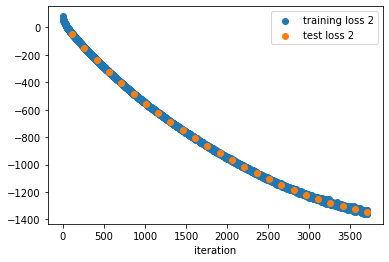

In [41]:
plt.figure()
iterations = np.arange(1, len(training_loss2[40:]) + 1)
plt.scatter(iterations, training_loss2[40:], label='training loss 2')
plt.scatter(iterations, test_loss2[40:], label='test loss 2')
plt.legend()
plt.xlabel('iteration')
plt.show()

## Task 7

Read through and try to understand the implementation of the training procedure above. How does it differ from the implementation of the training procedure of the nonlinear model without encoder?

In contrast to the regular nonlinear model without encoder, we can encode the images of the MNIST data set and repeat the same analysis as for the PPCA model.

In [49]:
model = model2

In [572]:
print(np.shape(train_data.dataset.data))
print(np.shape(train_data.dataset.data))
print(np.shape(test_dataset.data))
print(np.shape(train_data.dataset.targets))

torch.Size([60000, 28, 28])
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])


In [50]:


with torch.no_grad():
    # compute representative encoding of the training images
    train_encoding, _ = model.encode(train_data.dataset.data.reshape(60000,28*28)/255)

    # compute representative encoding of the test images
    test_encoding, _ = model.encode(test_images.data.reshape(10000,28*28)/255)

We visualize the encodings.

In [326]:
print(train_encoding[1])

tensor([ 0.4154, -0.0196])


torch.Size([60000, 2])
torch.Size([60000, 2])


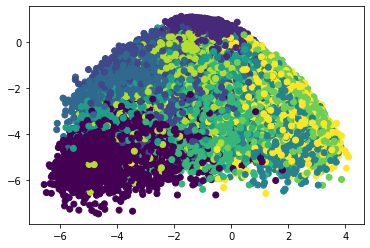

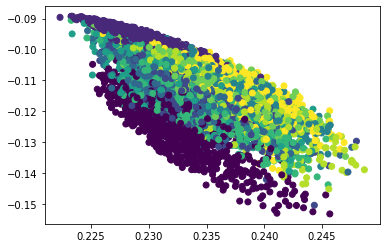

In [51]:
#plot_encoding((train_encoding, train_labels), (test_encoding, test_labels))
print(np.shape(train_encoding))
print(np.shape(train_encoding))
colors = train_labels

plt.scatter(train_encoding[:,0], train_encoding[:,1], c=colors)
plt.show()
colors = test_labels
plt.scatter(test_encoding[:,0], test_encoding[:,1], c=colors)
#plt.scatter(test_encoding[0:,0,0], test_encoding[0:,0,1], c="black", marker="x")
#for tex, enc in zip(test_labels, test_encoding):
#  plt.text(enc[0], enc[1], tex, horizontalalignment='left', size='medium', color='blue', weight='semibold')
#for enc in train_encoding:
#  plt.plot(enc[0], enc[1], '.')

For each of the digits 0, 1, $\ldots$, 9 we compute the average representation in the latent space by taking the mean of the encodings of the MNIST training data set.

In [52]:
# compute mean encoding
#train_mean_encodings = mean_encodings(train_encoding, train_labels)
print(np.shape(np.where(train_labels == 1)))
temp_train = np.asarray(train_encoding)
train_mean_encodings = np.zeros([10,2])
#train_mean_encodings = []
for i in range(0,10):
  dat = temp_train[np.where(train_labels == i)]
  x = dat[:,0]
  y = dat[:,1]
  #train_mean_encodings.append([np.mean(x), np.mean(y)])
  train_mean_encodings[i,0] = np.mean(x)
  train_mean_encodings[i,1] = np.mean(y)

(1, 6742)


In [329]:
print(np.shape(train_mean_encodings))

(10, 2)


We visualize their location in the latent space.

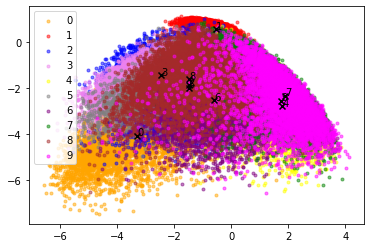

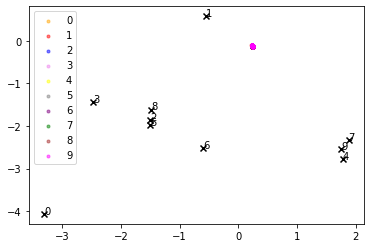

In [53]:
cdict = {0: 'orange', 1: 'red', 2: 'blue', 3: 'violet', 4: 'yellow', 5: 'grey', 6: 'purple', 7: 'green', 8: 'brown', 9: 'magenta'}
n = [0,1,2,3,4,5,6,7,8,9]

fig, ax = plt.subplots()
for g in np.unique(train_labels):
    ix = np.where(train_labels == g)
    ax.scatter(train_encoding[ix,0], train_encoding[ix,1], c = cdict[g], label = g, marker='.', alpha=0.5)
ax.legend()
plt.scatter(train_mean_encodings[:,0],train_mean_encodings[:,1], color='black', marker='x')

for i, txt in enumerate(n):
    ax.annotate(txt, (train_mean_encodings[i,0], train_mean_encodings[i,1]))
plt.show()

fig, ax = plt.subplots()
for g in np.unique(test_labels):
    ix = np.where(test_labels == g)
    ax.scatter(test_encoding[ix,0], test_encoding[ix,1], c = cdict[g], label = g, marker='.', alpha=0.5)
ax.legend()
plt.scatter(train_mean_encodings[:,0],train_mean_encodings[:,1], color='black', marker='x')

for i, txt in enumerate(n):
    ax.annotate(txt, (train_mean_encodings[i,0], train_mean_encodings[i,1]))
plt.show()



Of course, we can also decode the latent encodings with our model.

In [54]:
# compute mean images
train_mean_tensor = torch.tensor(train_mean_encodings)

with torch.no_grad():
    train_mean_images = model.decode(train_mean_tensor.float())

print(np.shape(train_mean_images))

torch.Size([10, 784])


tensor(0.7682)


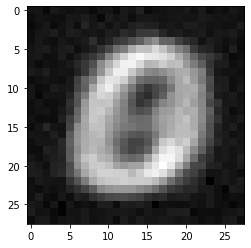

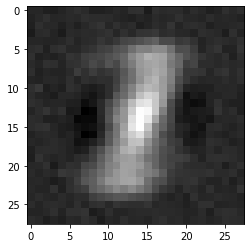

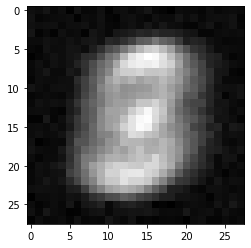

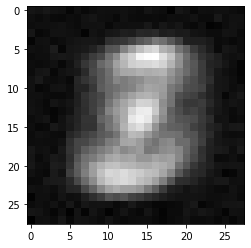

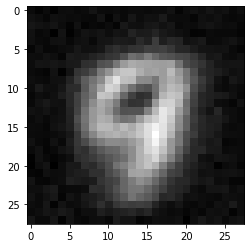

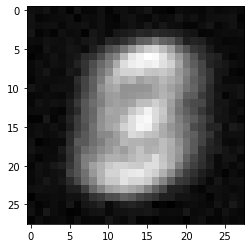

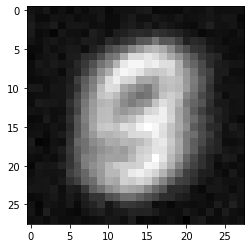

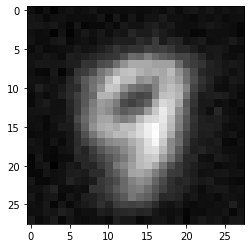

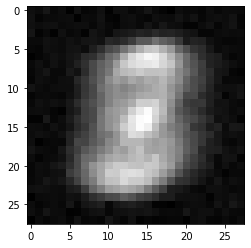

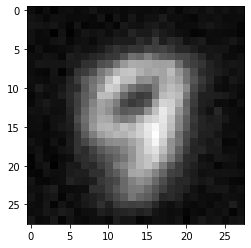

In [55]:
# compute mean images
#with torch.no_grad():
#    train_mean_images = model.decode(train_mean_encodings)

#plot_images(train_mean_images, torch.arange(10))
print(max(train_mean_images[1]))

  #print(np.shape(img.reshape(28,28)))
for img in train_mean_images:
  numimg = img.reshape(28,28)#/max(img)

  plt.imshow(numimg, cmap='gray')
  plt.show()

Let us get a feeling for the distribution in the latent space by defining and analysing a whole grid of encodings, spanned by the mean encodings of the digits "0" and "9".

In [333]:
# compute grid of latent vectors
zgrid = create_grid(train_mean_encodings[0], train_mean_encodings[9])

# visualize it
plot_encoding((train_encoding, train_labels), (test_encoding, test_labels), zgrid)

NameError: name 'create_grid' is not defined

We show the corresponding decoded images.

In [334]:
# compute mean images
with torch.no_grad():
    xgrid = model.decode(zgrid)

plot_images(xgrid)

NameError: name 'zgrid' is not defined

As in the previous parts of the lab session, we also compare the test images with their reconstructions to see how much information we lose by encoding the MNIST images in a two-dimensional space. We plot a set of images and their reconstructions, and compute the average squared reconstruction error as a more objective measure.

In [ ]:
# compute reconstruction
with torch.no_grad():
    test_reconstruction = model.decode(test_encoding)

# compute average squared reconstruction error
sqerr = (test_images - test_reconstruction).pow(2).sum(dim=1).mean()
print(f"Average squared reconstruction error: {sqerr}")

plot_reconstruction(test_images, test_reconstruction, test_labels)

## Task 8

Now we have performed exactly the same analysis as for the regular and the probabilistic PCA. Compare your results and answer Questions 4.8, 4.9, and 4.10 in the lab instructions.

We can also generate new MNIST-like images in the same way as for the nonlinear model without encoder. Again we sample 25 vectors $\mathbf{z}_1, \ldots, \mathbf{z}_{25}$ from $\mathcal{N}(0, \mathbf{I}_{2})$, and plot the representative decoding $\mu_{\boldsymbol{\theta}}(\mathbf{z}_n)$.

In [ ]:
with torch.no_grad():
  x = sample_decode(model, 25)

plot_images(x)

## Summary

We have trained a variational autoencoder that allows us to generate MNIST-like images. Adding a nonlinearity and an encoder seems to improve the quality of the samples. However, we also notice that the model is not perfect. Many further modifications of the decoder and encoder models are possible and could potentially improve the sampler. For instance, the dimension of the latent space can be increased (then the information loss by encoding the images in the latent space should be reduced). Alternatively the nonlinear decoder model can be changed: a more flexible model with increased number of layers in the neural network or a diagonal (or even full) covariance matrix could be used, or the outputs could be restricted to values between 0 and 1 (since we represent MNIST images as vectors with entries between 0 and 1).